In [128]:
! pip install ipywidgets

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.utils.data as data
from pandas.plotting import parallel_coordinates

# (BoTorch imports for Bayesian optimization)
import botorch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.transforms import Normalize, Standardize
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import GreaterThan
import gpytorch

# Acquisition functions
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using BoTorch version: {botorch.__version__}")
print("Using device:", device)

Using BoTorch version: 0.14.0
Using device: cuda


In [130]:
# We have made the code verbose to help user understand the code better. You can set it to False if you want to suppress the output. 
verbose = 0 
verbose_  = 1

Workflow optimized such that :-
- GPU (float64)  ----> BoTorch
- GPU (float32)  ----> PyTorch (Neural Network)
- CPU  ------------------> Metrics Calculation

# Data Pre-processing

In [131]:
! ls ./.

1_eda_preprocess.ipynb
2_optuna.ipynb
3_botorch_lr.ipynb
3_botorch_nn.ipynb
3_botorch_nn_v2.ipynb
3_botorch_rf.ipynb
4_combining_pareto_from_all_models.ipynb
bank.csv
botorch_multi_objective_all_trials.png
botorch_multi_objective_pareto_frontier.png
final_pareto_of_combined_ensamble.csv
pareto_results.csv
processed_bank_marketing.csv
requirements.txt


In [132]:
# 1. Load your preprocessed CSV
df = pd.read_csv("processed_bank_marketing.csv")

# 2. Ensure no missing data
df = df.dropna()

# 3. Extract features, labels, and protected group
X = df.drop(columns=["deposit"])
y = df["deposit"].values
protected_attr = df["marital"].values  # 0, 1, 2 → single, married, divorced

# Ensure all columns are numeric (if necessary)
X = pd.get_dummies(X, drop_first=True)

# 4. Preprocess the data (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set device explicitly at the beginning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to tensors and move to gpu
X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
y_tensor = torch.tensor(y, dtype=torch.float64).view(-1, 1)
print(f"Initial tensor devices - X: {X_tensor.device}, y: {y_tensor.device}")
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)
print(f"After moving to device - X: {X_tensor.device}, y: {y_tensor.device}")

# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
    X_tensor, y_tensor, protected_attr, test_size=0.2, random_state=42
)

# Print device information for split data
print(f"Split data devices - X_train: {X_train.device}, y_train: {y_train.device}")
print(f"Split data devices - X_test: {X_test.device}, y_test: {y_test.device}")

# 6. Define fairness metric (max-min demographic parity across marital groups)
def demographic_parity_diff(y_pred, protected_group):
    group_probs = [
        y_pred[protected_group == g].mean()
        for g in np.unique(protected_group)
    ]
    return max(group_probs) - min(group_probs)

Using device: cuda
Initial tensor devices - X: cpu, y: cpu
After moving to device - X: cuda:0, y: cuda:0
Split data devices - X_train: cuda:0, y_train: cuda:0
Split data devices - X_test: cuda:0, y_test: cuda:0



# Nueral Net Definition

In [133]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_units, layers, activation_type, dropout_rate):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(f"Creating NeuralNetwork on device: {self.device}")
        # Map activation type string to function
        activation_map = {
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(),
            'Tanh': nn.Tanh()
        }
        activation = activation_map[activation_type]
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_units).to(self.device))
        self.layers.append(activation.to(self.device))
        
        if dropout_rate > 0:
            self.layers.append(nn.Dropout(dropout_rate).to(self.device))
        
        for _ in range(layers - 1):
            self.layers.append(nn.Linear(hidden_units, hidden_units).to(self.device))
            self.layers.append(activation.to(self.device))
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(dropout_rate).to(self.device))
        
        self.output_layer = nn.Linear(hidden_units, 1).to(self.device)
        self.sigmoid = nn.Sigmoid().to(self.device)
        # print(f"First layer device: {next(self.parameters()).device}")

    def forward(self, x):
        # Ensure x is float, throughout the code, we use double cuz of BoTorch's numerical stability 
        # (we ONLY use floats inside nn.Module) that way BOTH nn and BoTorch can work with the dtype they WORK BEST
        x = x.float() 
        
        # Print input device and type for debugging
        # print(f"Forward input device: {x.device}, dtype: {x.dtype}")
        
        if next(self.parameters()).is_cuda and not x.is_cuda:
            # print(f"Moving input from {x.device} to {next(self.parameters()).device}")
            x = x.cuda()
            
        for layer in self.layers:
            x = layer(x)
            
        output = self.sigmoid(self.output_layer(x))
        # print(f"Forward output device: {output.device}, dtype: {output.dtype}")
        return output


# Model Traning and Evaluation

In [134]:
def train_and_evaluate_nn(params):
    # Convert params to float32 before using in NN and ensure on correct device
    params = params.float().to(device) 
    if verbose : print(f"Converted params device: {params.device}, dtype: {params.dtype}")
    
    # Extract parameters
    layers = int(params[0].item())           # Number of layers
    units = int(params[1].item())            # Number of hidden units
    lr = 10 ** params[2].item()              # Learning rate (log scale)
    batch_size = int(params[3].item())       # Batch size
    optimizer_idx = int(params[4].item())    # Optimizer type (0: SGD, 1: Adam, 2: RMSprop)
    activation_idx = int(params[5].item())   # Activation function (0: ReLU, 1: LeakyReLU, 2: Tanh)
    dropout_rate = params[6].item()          # Dropout rate

    # Print the parameters
    # print(f"Training with: layers={layers}, units={units}, lr={lr:.6f}, batch_size={batch_size}, optimizer={optimizer_idx}, activation={activation_idx}, dropout={dropout_rate:.2f}")
    
    # Map indices to actual types
    optimizer_types = ['SGD', 'Adam', 'RMSprop']
    activation_types = ['ReLU', 'LeakyReLU', 'Tanh']
    
    optimizer_type = optimizer_types[optimizer_idx]
    activation_type = activation_types[activation_idx]
    
    # Print the parameters
    print(f"Training with: layers={layers}, units={units}, lr={lr:.6f}, batch_size={batch_size}, optimizer={optimizer_type}, activation={activation_type}, dropout={dropout_rate:.2f}")
    
    # Create data loaders - explicitly ensure data is on device
    train_data = data.TensorDataset(X_train.to(device), y_train.to(device))
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    # Initialize the model with new parameters
    model = NeuralNetwork(X_train.shape[1], units, layers, activation_type, dropout_rate)
    model.to(device)


    # Define loss and select optimizer based on optimizer_type
    criterion = nn.BCELoss()
    if optimizer_type == 'SGD': optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == 'Adam': optimizer = optim.Adam(model.parameters(), lr=lr)
    else: optimizer = optim.RMSprop(model.parameters(), lr=lr)

    # Train the model
    epochs = 100
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Ensure data is on correct device with correct dtype
            X_batch = X_batch.float().to(device) 
            y_batch = y_batch.float().to(device)
            
            if verbose and (epoch == 0 and running_loss == 0.0) :  # Only print once for the first batch
                if verbose : print(f"First batch - X_batch: {X_batch.device}, dtype: {X_batch.dtype}")
                if verbose : print(f"First batch - y_batch: {y_batch.device}, dtype: {y_batch.dtype}")
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Print loss occasionally
        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        # print(f"X_test device before eval: {X_test.device}, dtype: {X_test.dtype}")
        X_test_device = X_test.to(device)
        # print(f"X_test device for eval: {X_test_device.device}, dtype: {X_test_device.dtype}")
        
        y_pred = model(X_test_device)
        # print(f"y_pred device after model: {y_pred.device}, dtype: {y_pred.dtype}")
        
        y_pred_class = (y_pred > 0.5).float()
        # print(f"y_pred_class device: {y_pred_class.device}, dtype: {y_pred_class.dtype}")
        
        # Move tensors to CPU for numpy conversion and metrics calculation
        y_pred_class_cpu = y_pred_class.cpu()
        # print(f"y_pred_class_cpu device: {y_pred_class_cpu.device}, dtype: {y_pred_class_cpu.dtype}")
        
        y_test_cpu = y_test.cpu()
        # print(f"y_test_cpu device: {y_test_cpu.device}, dtype: {y_test_cpu.dtype}")
    
    # Calculate accuracy and fairness
    acc = accuracy_score(y_test_cpu.numpy(), y_pred_class_cpu.numpy())
    fairness = demographic_parity_diff(y_pred_class_cpu.numpy(), m_test)
    
    print(f"  Results: Accuracy = {acc:.4f}, Fairness = {fairness:.4f}")
    
    # Return results as float64 for BoTorch and ensure on device
    result = torch.tensor([acc, -fairness], dtype=torch.float64).to(device)
    if verbose : print(f"Return tensor device: {result.device}, dtype: {result.dtype}")
    return result

# Bayesian Optimization ( Fitting a GP as surrogate )

In [135]:
def manual_fit_gp(model, train_x, train_y, training_iter=100, lr=0.01):
    # Check input tensors
    if verbose : print(f"manual_fit_gp - train_x: {train_x.device}, dtype: {train_x.dtype}")
    if verbose : print(f"manual_fit_gp - train_y: {train_y.device}, dtype: {train_y.dtype}")
    if verbose_ : print([name for name, _ in model.named_parameters()])

    # Ensure inputs match the model's expected format
    train_x = train_x.to(dtype=torch.float64)
    train_y = train_y.to(dtype=torch.float64)
    
    # Get device from model parameters
    model_device = next(model.parameters()).device
    if verbose : print(f"GP model device: {model_device}")
    if verbose : print([name for name, _ in model.named_parameters()])
    
    # Move inputs to model's device
    train_x = train_x.to(model_device)
    train_y = train_y.to(model_device)
    if verbose : print(f"After moving - train_x: {train_x.device}, train_y: {train_y.device}")

    # SAFE CONSTRAINT REGISTRATION - MODIFIED FOR YOUR MODEL
    def safe_register_constraint(module, param_name):
        if hasattr(module, param_name):
            constraint = GreaterThan(1e-6)
            module.register_constraint(param_name, constraint)
            if verbose_: print(f"Registered constraint for {param_name}")
    # Only register constraints for parameters that exist in your model
    if hasattr(model, 'covar_module') and hasattr(model.covar_module, 'raw_lengthscale'):
        safe_register_constraint(model.covar_module, "raw_lengthscale")
    if hasattr(model, 'likelihood') and hasattr(model.likelihood.noise_covar, 'raw_noise'):
        safe_register_constraint(model.likelihood.noise_covar, "raw_noise")
    
    model.train()
    model.likelihood.train()
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Define a robust training loop with error handling
    for i in range(training_iter):
        try:
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y).sum()
            # Check if loss is valid before backward
            if not torch.isfinite(loss):
                print(f"  Warning: Non-finite loss detected at iter {i}, skipping this step")
                continue
            loss.backward()
            optimizer.step()
            if i % 25 == 0:  # Print every 25 iterations
                print(f"  GP training iter {i}, loss: {loss.item():.4f}")
        except ValueError as e:
            print(f"  ValueError in GP training at iter {i}: {str(e)}")
            # Try to adjust model parameters to avoid negative values
            for param in model.parameters():
                if param.grad is not None:
                    # Apply a small positive shift to any problematic parameters
                    if torch.any(param < 0):
                        with torch.no_grad():
                            param.copy_(torch.clamp(param, min=1e-5))
        except Exception as e:
            print(f"  Error in GP training at iter {i}: {str(e)}")
    
    return model


# Define parameter bounds for BoTorch
# bounds = torch.tensor([
#     [1.0, 32.0, -5.0, 16.0],   # lower bounds: layers, units, log_lr, batch_size
#     [4.0, 128.0, -1.0, 256.0]  # upper bounds: layers, units, log_lr, batch_size
# ], dtype=torch.float64)

bounds = torch.tensor([
    [1.0, 32.0, -5.0, 16.0, 0.0, 0.0, 0.0],   # lower: layers, units, log_lr, batch_size, optimizer_idx, activation_idx, dropout
    [4.0, 128.0, -1.0, 256.0, 2.0, 2.0, 0.5]  # upper: layers, units, log_lr, batch_size, optimizer_idx, activation_idx, dropout
], dtype=torch.float64)


import warnings
from linear_operator.utils.cholesky import NumericalWarning
warnings.filterwarnings("ignore", category=NumericalWarning)

# Make sure bounds are on the device
if verbose : print(f"Bounds initial device: {bounds.device}, dtype: {bounds.dtype}")
bounds = bounds.to(device)
if verbose : print(f"Bounds after moving: {bounds.device}, dtype: {bounds.dtype}")


# Generate initial points with multi-objective evaluation
def generate_initial_points(n_samples=4):
    print(f"Generating {n_samples} initial random points...")
    # Generate random points within bounds
    print(f"Device for random generation: {device}")
    X_init = torch.rand(n_samples, 7, dtype=torch.float64, device=device) 
    X_init = bounds[0] + X_init * (bounds[1] - bounds[0])   # Scale to the parameter ranges
    print(f"X_init device: {X_init.device}, dtype: {X_init.dtype}")

    # Round the optimizer and activation indices to integers
    X_init[:, 4] = torch.floor(X_init[:, 4])  # Optimizer index as integers
    X_init[:, 5] = torch.floor(X_init[:, 5])  # Activation index as integers
    
    # Evaluate each point
    Y_init = torch.zeros(n_samples, 2, dtype=torch.float64, device=device) 
    print(f"Y_init device: {Y_init.device}, dtype: {Y_init.dtype}")
    
    for i in range(n_samples):
        print(f"\nEvaluating initial point {i+1}/{n_samples}")
        if verbose : print(f"Point {i+1} device: {X_init[i].device}, dtype: {X_init[i].dtype}")
        results = train_and_evaluate_nn(X_init[i])
        if verbose : print(f"Results device: {results.device}, dtype: {results.dtype}")
        Y_init[i] = results
        if verbose : print(f"Y_init[{i}] updated device: {Y_init[i].device}, dtype: {Y_init[i].dtype}")
        print(f"  Trial {i+1}: acc={results[0]:.4f}, fairness={-results[1]:.4f}")
        
    return X_init, Y_init

# Running BoTorch MOO

In [136]:
# Run Multi-Objective Bayesian optimization with BoTorch
def run_botorch_multi_objective_optimization(n_iterations=90):
    print("\nInitializing with random trials...")
    X_train, Y_train = generate_initial_points(n_samples=30)

    print(f"After initial points - X_train: {X_train.device}, dtype: {X_train.dtype}")
    print(f"After initial points - Y_train: {Y_train.device}, dtype: {Y_train.dtype}")
    
    # Explicitly ensure they're on the correct device
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    print(f"After explicit device move - X_train: {X_train.device}, Y_train: {Y_train.device}")
    
    # Store all results
    all_X = X_train.clone()
    all_Y = Y_train.clone()
    
    # Set up reference point for hypervolume calculation
    # This represents the minimum acceptable performance
    # [min_accuracy, min_negative_fairness]
    ref_point = torch.tensor([0.2, -0.3], dtype=torch.float64, device=device)  
    print(f"Reference point device: {ref_point.device}, dtype: {ref_point.dtype}")
    
    print(f"Starting optimization for {n_iterations} iterations...")
    
    # Normalize your input parameters to [0,1] range before passing to GP
    def normalize_params(X, bounds):
        normalized = (X - bounds[0]) / (bounds[1] - bounds[0])
        print(f"Normalized params device: {normalized.device}, dtype: {normalized.dtype}")
        return normalized

    # Check before GP training:
    X_train_normalized = normalize_params(X_train, bounds)
    print(f"X_train_normalized device: {X_train_normalized.device}, dtype: {X_train_normalized.dtype}")
    print(f"Y_train device: {Y_train.device}, dtype: {Y_train.dtype}")
    
    # Additional assertions for debugging
    assert X_train_normalized.device == Y_train.device, "X and Y must be on same device"
    assert X_train_normalized.dtype == torch.float64, "X must be float64 for BoTorch"
    assert Y_train.dtype == torch.float64, "Y must be float64 for BoTorch"

    for i in range(n_iterations):
        try:
            print(f"\n===== ITERATION {i+1}/{n_iterations} =====")
            print(f"Current X_train device: {X_train.device}, Y_train device: {Y_train.device}")
            
            # 1. Fit a multi-output GP model (we need a separate GP for each objective)
            models = []
            for j in range(Y_train.shape[1]):
                print(f"Creating GP model for objective {j+1}")
                
                # Re-normalize and ensure on correct device for this iteration
                X_train_normalized = normalize_params(X_train, bounds).to(device)
                Y_train_obj = Y_train[:, j:j+1].to(device)
                
                print(f"Training GP {j+1} - X: {X_train_normalized.device}, Y: {Y_train_obj.device}")
                
                # Create the GP model
                gp = SingleTaskGP(
                    train_X=X_train_normalized, 
                    train_Y=Y_train_obj,
                    input_transform=Normalize(d=X_train_normalized.shape[-1]),
                    outcome_transform=Standardize(m=1)
                ).to(device)  # Explicitly set device
                
                if verbose : print(f"GP {j+1} device: {next(gp.parameters()).device}")
                
                # Manual fitting - ensure inputs match model device
                gp = manual_fit_gp(gp, X_train_normalized, Y_train_obj, lr=0.01)
                models.append(gp)
            
            # Combine models into a ModelListGP
            model = ModelListGP(*models)
            if verbose : print(f"Combined model device: {next(model.parameters()).device}")
            
            # 2. Current Pareto frontier
            if verbose : print(f"Pareto frontier Y device: {Y_train.device}")
            
            # Create a partitioning of the non-dominated space
            partitioning = NondominatedPartitioning(ref_point=ref_point, Y=Y_train)
            
            # 3. Define the acquisition function
            acq_func =  qLogExpectedHypervolumeImprovement (
                model=model,
                ref_point=ref_point.tolist(),
                partitioning=partitioning,
                objective=IdentityMCMultiOutputObjective()
            )
                
            if verbose : print("\nInput validation before optimize_acqf:")
            if verbose : print(f"Model training inputs: {model.train_inputs[0][0].device}, {model.train_inputs[0][0].dtype}")
            if verbose : print(f"Acquisition bounds: {bounds.device}, {bounds.dtype}")
            if verbose : print(f"X_train_normalized: {X_train_normalized.device}, {X_train_normalized.dtype}")
                
            # 4. Optimize the acquisition function
            candidate, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=torch.tensor([[0.0] * 7, [1.0] * 7], device=device, dtype=torch.float64),  # Normalized bounds
                q=1,
                num_restarts=10,
                raw_samples=64
            )
            
            # Map candidate back to original space
            candidate = bounds[0] + candidate * (bounds[1] - bounds[0])
            print(f"[FOUND THORUGH BO]  Optimized candidate device: {candidate.device}, dtype: {candidate.dtype}")
            
        except Exception as e:
            # Random sampling as fallback
            print(f"Error during Bayesion optimization via GP  : {str(e)}")
            print(f"Falling back to random sampling...")
            candidate = bounds[0] + torch.rand(1, 7, device=device, dtype=torch.float64) * (bounds[1] - bounds[0])
            print(f"Candidate device: {candidate.device}, dtype: {candidate.dtype}")
        
        # 5. Evaluate the new candidate
        print(f"\nIteration {i+1}/{n_iterations}:")
        print(f"Candidate: layers={int(candidate[0,0].item())}, units={int(candidate[0,1].item())}, "
              f"lr={10**candidate[0,2].item():.6f}, batch_size={int(candidate[0,3].item())}")
        
        # Ensure candidate is on the right device before evaluation
        candidate = candidate.to(device)
        if verbose : print(f"Candidate device before evaluation: {candidate.device}")
        
        # Evaluate and get results
        results = train_and_evaluate_nn(candidate[0])
        if verbose : print(f"Results after evaluation: {results.device}, dtype: {results.dtype}")
        
        # 6. Update training data - ENSURE SAME DEVICE
        # Create new tensors on the same device
        new_X = candidate.to(device)
        new_Y = results.unsqueeze(0).to(device)
        
        if verbose : print(f"Before concatenation - X_train: {X_train.device}, new_X: {new_X.device}")
        if verbose : print(f"Before concatenation - Y_train: {Y_train.device}, new_Y: {new_Y.device}")
        
        X_train = torch.cat([X_train, new_X])
        Y_train = torch.cat([Y_train, new_Y])
        
        if verbose : print(f"After concatenation - X_train: {X_train.device}, Y_train: {Y_train.device}")
        
        # 7. Store all results (also ensure same device)
        all_X = torch.cat([all_X, new_X])
        all_Y = torch.cat([all_Y, new_Y])
        
    # Return all evaluated configurations and their performances
    return all_X, all_Y


# Run optimization
print("Starting Multi-Objective BoTorch optimization for Neural Network...")
all_X, all_Y = run_botorch_multi_objective_optimization(n_iterations=300)

Starting Multi-Objective BoTorch optimization for Neural Network...

Initializing with random trials...
Generating 30 initial random points...
Device for random generation: cuda
X_init device: cuda:0, dtype: torch.float64
Y_init device: cuda:0, dtype: torch.float64

Evaluating initial point 1/30
Training with: layers=2, units=78, lr=0.000929, batch_size=90, optimizer=Adam, activation=ReLU, dropout=0.28
  Epoch 20/100, Loss: 0.4018
  Epoch 40/100, Loss: 0.3869
  Epoch 60/100, Loss: 0.3751
  Epoch 80/100, Loss: 0.3700
  Epoch 100/100, Loss: 0.3542
  Results: Accuracy = 0.8173, Fairness = 0.1477
  Trial 1: acc=0.8173, fairness=0.1477

Evaluating initial point 2/30
Training with: layers=1, units=96, lr=0.000015, batch_size=133, optimizer=Adam, activation=LeakyReLU, dropout=0.19
  Epoch 20/100, Loss: 0.6480
  Epoch 40/100, Loss: 0.6031
  Epoch 60/100, Loss: 0.5652
  Epoch 80/100, Loss: 0.5383
  Epoch 100/100, Loss: 0.5157
  Results: Accuracy = 0.7779, Fairness = 0.2260
  Trial 2: acc=0.7779

In [146]:
all_X, all_Y = all_X.cpu(), all_Y.cpu()  # Move to CPU for plotting

# Extract results
accuracies = all_Y[:, 0].numpy()
fairness_values = -all_Y[:, 1].numpy()  # Convert back to positive values

# Exploration and Pareto Points 

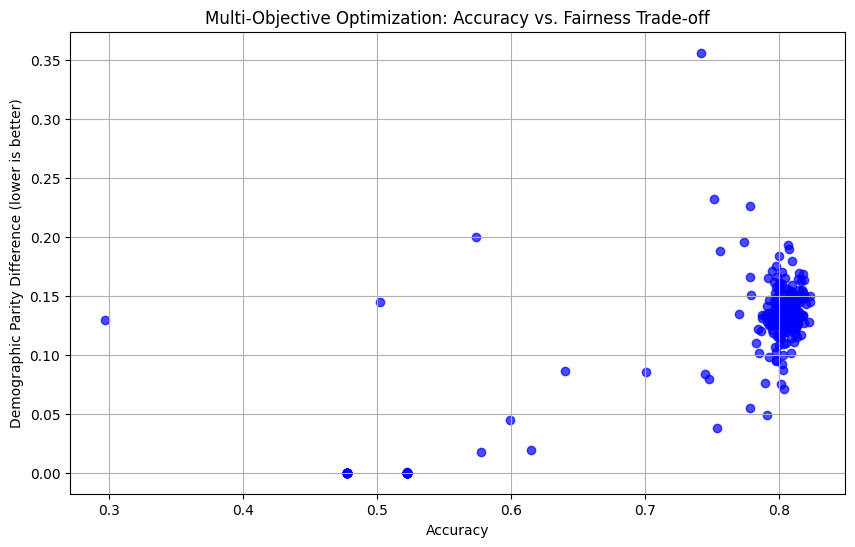

In [147]:
# 15. Plot the results (All trials)
plt.figure(figsize=(10, 6))
plt.scatter(accuracies, fairness_values, c="blue", alpha=0.7)
plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Multi-Objective Optimization: Accuracy vs. Fairness Trade-off")
plt.grid(True)
plt.savefig("botorch_multi_objective_all_trials.png")
plt.show()

# Find and visualize the Pareto frontier
# Helper function to determine if a point is Pareto-optimal
def is_pareto_optimal(accuracies, fairness_values, idx):
    # For each candidate solution
    for i in range(len(accuracies)):
        if i != idx:  # Don't compare with itself
            # If another solution has better accuracy and better (lower) fairness
            if accuracies[i] >= accuracies[idx] and fairness_values[i] <= fairness_values[idx] and (
                accuracies[i] > accuracies[idx] or fairness_values[i] < fairness_values[idx]
            ):
                return False  # Not Pareto-optimal
    return True  # No better solution exists


# Function to filter the Pareto front to get better spread (if too many points)
def filter_pareto_front(accuracies, fairness_values, target_points=40):
    """Filter Pareto front to get a well-distributed set of points"""
    if len(accuracies) <= target_points:
        return np.arange(len(accuracies))
    
    # Sort by accuracy
    sort_idx = np.argsort(accuracies)
    acc_sorted = accuracies[sort_idx]
    fair_sorted = fairness_values[sort_idx]
    
    # Calculate ranges
    acc_range = acc_sorted[-1] - acc_sorted[0]
    fair_range = fair_sorted[-1] - fair_sorted[0]
    
    # Always keep endpoints
    keep_indices = [sort_idx[0], sort_idx[-1]]
    
    # Select points with approximately equal spacing in the normalized space
    points_to_add = target_points - 2
    
    if points_to_add > 0:
        step = len(acc_sorted) // (points_to_add + 1)
        for i in range(1, points_to_add + 1):
            idx = min(i * step, len(sort_idx) - 1)
            keep_indices.append(sort_idx[idx])
    return np.array(keep_indices)


# Find Pareto-optimal points
pareto_optimal = [
    is_pareto_optimal(accuracies, fairness_values, i)
    for i in range(len(accuracies))
]

# Extract Pareto-optimal solutions
pareto_accuracies = accuracies[pareto_optimal]
pareto_fairness = fairness_values[pareto_optimal]
pareto_indices = np.where(pareto_optimal)[0]

# Sort by accuracy for connecting the Pareto frontier
pareto_sort_idx = np.argsort(pareto_accuracies)
pareto_accuracies = pareto_accuracies[pareto_sort_idx]
pareto_fairness = pareto_fairness[pareto_sort_idx]
pareto_indices = pareto_indices[pareto_sort_idx]

In [148]:
# Filter if we have too many points, to get a better spread
print(f"Found {len(pareto_indices)} Pareto-optimal points")
if len(pareto_indices) > 40:
    # Filter to get a good spread of points
    filtered_indices = filter_pareto_front(pareto_accuracies, pareto_fairness, target_points=40)
    pareto_accuracies = pareto_accuracies[filtered_indices]
    pareto_fairness = pareto_fairness[filtered_indices]
    pareto_indices = pareto_indices[filtered_indices]
    print(f"Filtered to {len(pareto_indices)} well-distributed points on the Pareto frontier")

# Extract parameters for Pareto-optimal solutions
pareto_params = all_X[pareto_indices].numpy()

Found 45 Pareto-optimal points
Filtered to 40 well-distributed points on the Pareto frontier



Pareto-Optimal Neural Network Configurations:
1. layers=4, units=32, lr=0.100000, batch_size=16, optimizer=RMSprop, activation=ReLU, dropout=0, acc=0.5222, fairness=0.0000000000
2. layers=2, units=55, lr=0.001444, batch_size=103, optimizer=Adam, activation=ReLU, dropout=0, acc=0.8227, fairness=0.1446450949
3. layers=2, units=32, lr=0.100000, batch_size=16, optimizer=RMSprop, activation=ReLU, dropout=0, acc=0.5222, fairness=0.0000000000
4. layers=3, units=32, lr=0.100000, batch_size=16, optimizer=RMSprop, activation=ReLU, dropout=0, acc=0.5222, fairness=0.0000000000
5. layers=2, units=32, lr=0.100000, batch_size=16, optimizer=RMSprop, activation=ReLU, dropout=0, acc=0.5222, fairness=0.0000000000
6. layers=2, units=32, lr=0.100000, batch_size=16, optimizer=RMSprop, activation=ReLU, dropout=0, acc=0.5222, fairness=0.0000000000
7. layers=4, units=32, lr=0.100000, batch_size=16, optimizer=RMSprop, activation=ReLU, dropout=0, acc=0.5222, fairness=0.0000000000
8. layers=4, units=32, lr=0.100

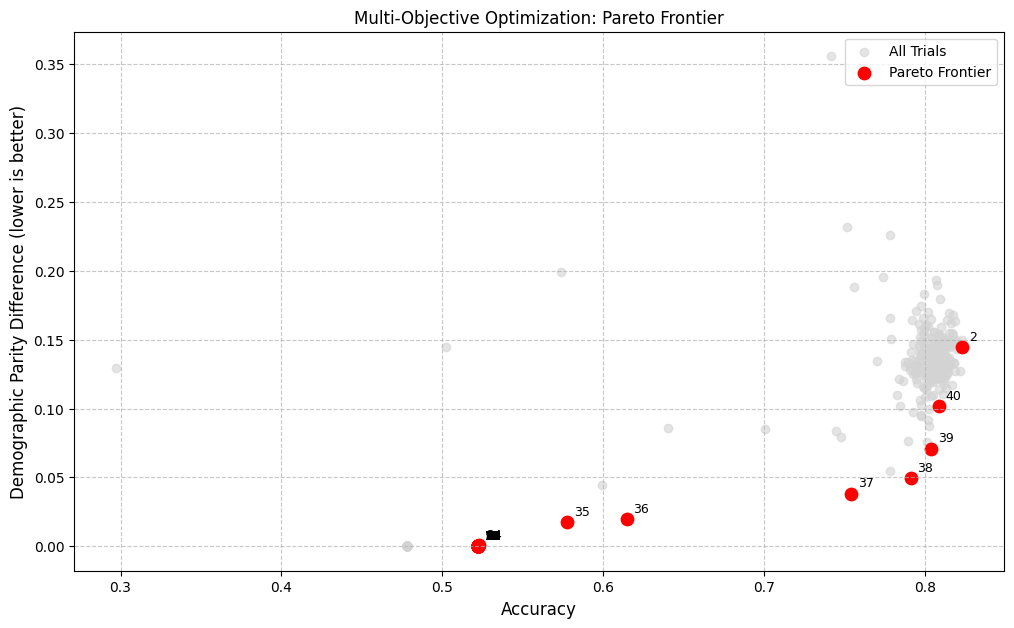

In [152]:
#  Print Pareto-optimal parameter settings
optimizer_types = ['SGD', 'Adam', 'RMSprop']
activation_types = ['ReLU', 'LeakyReLU', 'Tanh']

print("\nPareto-Optimal Neural Network Configurations:")
for i in range(len(pareto_indices)):
    idx = pareto_indices[i]
    params = {
        "layers": int(all_X[idx, 0].item()),
        "units": int(all_X[idx, 1].item()),
        "learning_rate": 10 ** all_X[idx, 2].item(),
        "batch_size": int(all_X[idx, 3].item()),
        "optimizer": optimizer_types[int(all_X[idx, 4].item())],
        "activation": activation_types[int(all_X[idx, 5].item())],
        "dropout": int(all_X[idx, 5].item())
    }
    print(f"{i+1}. layers={params['layers']}, units={params['units']}, "
          f"lr={params['learning_rate']:.6f}, batch_size={params['batch_size']}, "
          f"optimizer={params['optimizer']}, activation={params['activation']}, dropout={params['dropout']}, "
          f"acc={accuracies[idx]:.4f}, fairness={fairness_values[idx]:.10f}")

# Visualize the Pareto frontier
plt.figure(figsize=(12, 7))
plt.scatter(accuracies, fairness_values, color="lightgray", alpha=0.6, label="All Trials")
plt.scatter(pareto_accuracies, pareto_fairness, color="red", s=80, label="Pareto Frontier")
# plt.plot(pareto_accuracies, pareto_fairness, 'r--', alpha=0.7)  # Connect Pareto points

# Add annotations
for i, (x, y) in enumerate(zip(pareto_accuracies, pareto_fairness)):
    plt.annotate(f"{i+1}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=9)

# Add detailed formatting
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Fairness Gap (lower is better)", fontsize=12)
plt.title("Multi-Objective Optimization: Pareto Frontier", fontsize=14)
plt.legend(fontsize=11)

plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Multi-Objective Optimization: Pareto Frontier")
plt.legend()
plt.grid(True)
plt.savefig("botorch_multi_objective_pareto_frontier.png")
plt.show()

In [141]:
import csv
with open('pareto_results.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    for i in range(len(pareto_indices)):
        idx = pareto_indices[i]
        params = {
            "layers": int(all_X[idx, 0].item()),
            "units": int(all_X[idx, 1].item()),
            "learning_rate": 10 ** all_X[idx, 2].item(),
            "batch_size": int(all_X[idx, 3].item()),
            "optimizer": optimizer_types[int(all_X[idx, 4].item())],
            "activation": activation_types[int(all_X[idx, 5].item())],
            "dropout": int(all_X[idx, 5].item())
        }
        writer.writerow([
            'Botorch', 'NN',
            accuracies[idx],
            fairness_values[idx],
            str(params)
        ])

# Additional Visualizations

In [142]:
# Create a parallel coordinates plot to visualize parameters of Pareto solutions
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
pareto_df = pd.DataFrame({
    'layers': pareto_params[:, 0],
    'units': pareto_params[:, 1],
    'log_lr': pareto_params[:, 2],
    'batch_size': pareto_params[:, 3],
    'accuracy': pareto_accuracies,
    'fairness': pareto_fairness,
    'config_id': range(1, len(pareto_params) + 1)
})

## PART A :- Parameter analysis for Pareto-optimal solutions

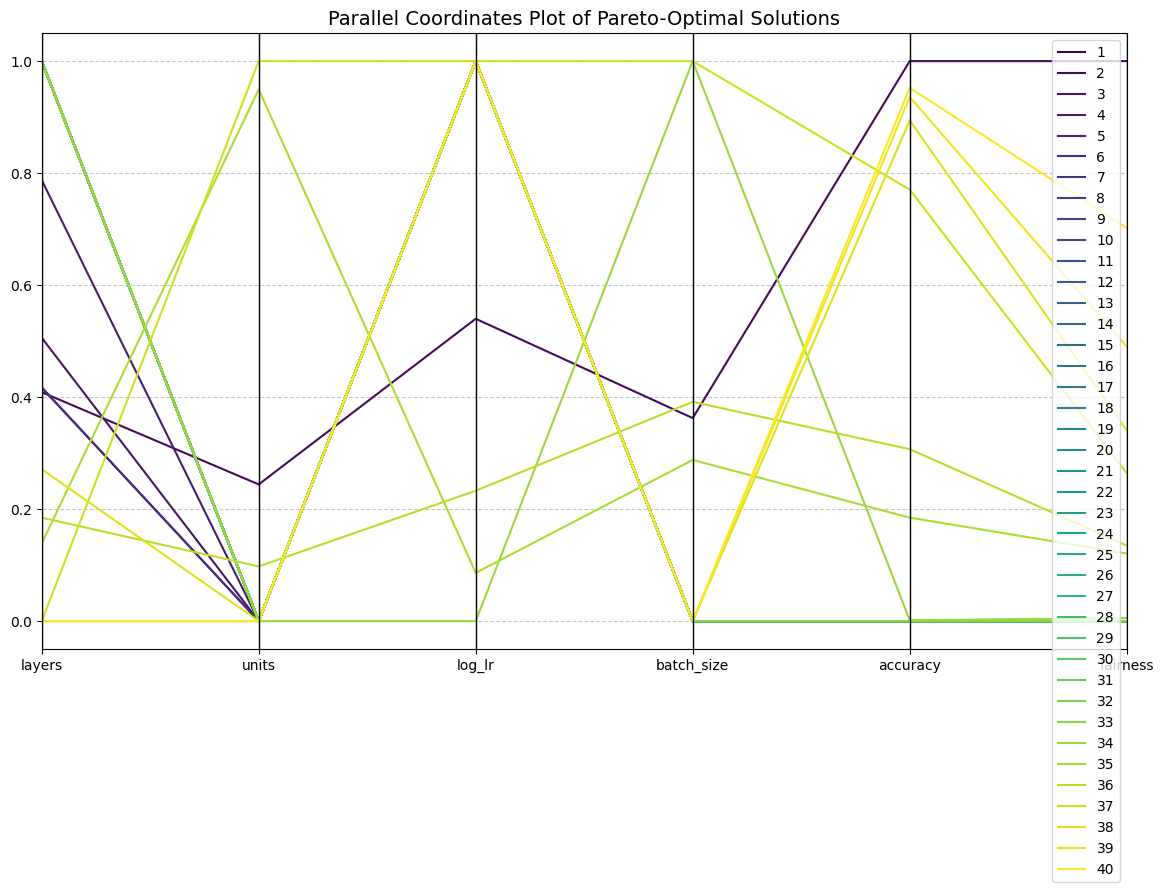

In [143]:
# Parameter analysis for Pareto-optimal solutions
pareto_params = all_X[pareto_indices].numpy()

# Normalize the parameters for better visualization
for col in ['layers', 'units', 'log_lr', 'batch_size', 'accuracy', 'fairness']:
    pareto_df[col] = (pareto_df[col] - pareto_df[col].min()) / (pareto_df[col].max() - pareto_df[col].min())

plt.figure(figsize=(14, 8))
parallel_coordinates(pareto_df, 'config_id', colormap='viridis')
plt.title('Parallel Coordinates Plot of Pareto-Optimal Solutions', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("botorch_multi_objective_parallel_coords.png")
plt.show()

## PART B :- 3D visualization of the parameter space

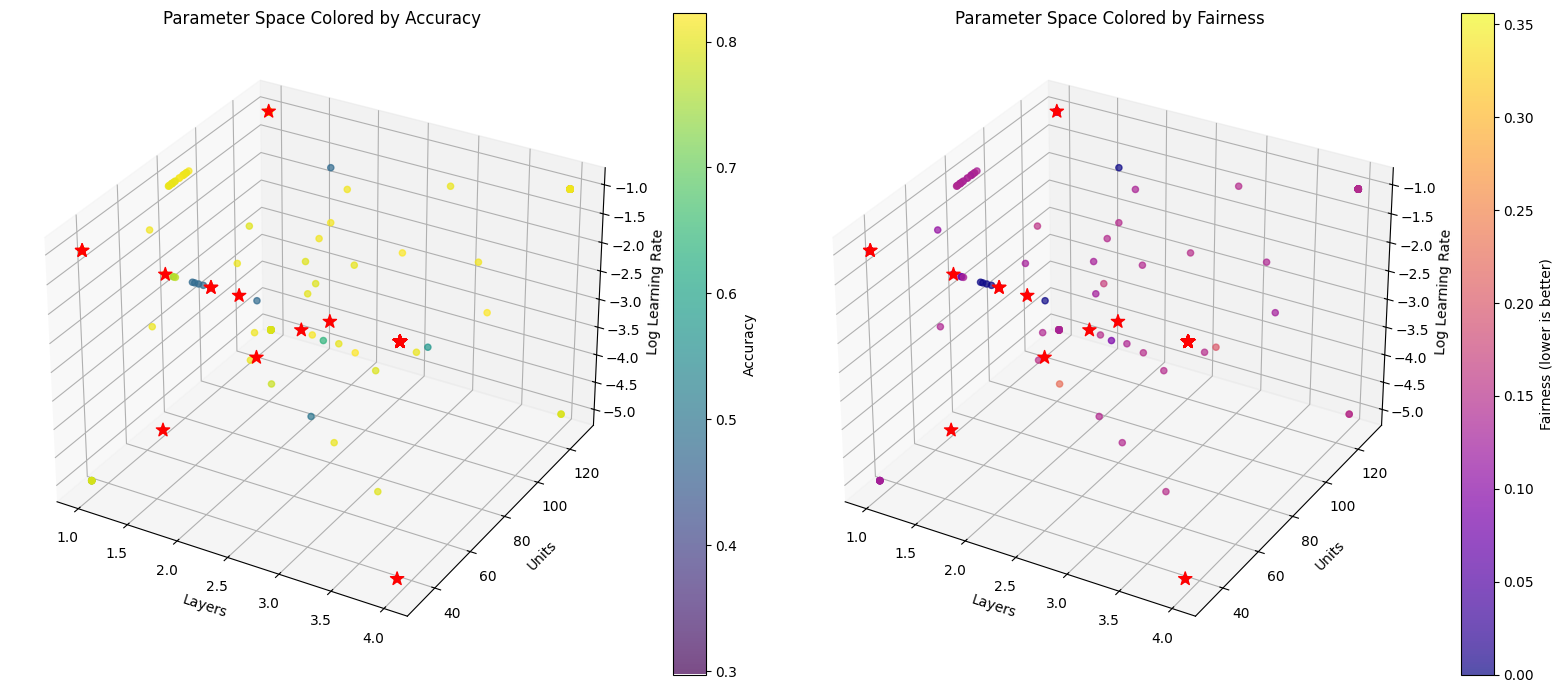

In [144]:
# 3D visualization of the parameter space
from mpl_toolkits.mplot3d import Axes3D

# Create a figure with two subplots
fig = plt.figure(figsize=(16, 7))

# Plot 1: Layers vs Units, colored by accuracy
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    all_X[:, 0].numpy(),  # layers
    all_X[:, 1].numpy(),  # units
    all_X[:, 2].numpy(),  # log learning rate
    c=accuracies,
    cmap='viridis',
    alpha=0.7
)
ax1.set_xlabel('Layers')
ax1.set_ylabel('Units')
ax1.set_zlabel('Log Learning Rate')
plt.colorbar(scatter1, ax=ax1, label='Accuracy')
ax1.set_title('Parameter Space Colored by Accuracy')

# Highlight Pareto-optimal points
ax1.scatter(
    pareto_params[:, 0],
    pareto_params[:, 1],
    pareto_params[:, 2],
    color='red',
    s=100,
    alpha=1.0,
    marker='*'
)

# Plot 2: Layers vs Units, colored by fairness
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    all_X[:, 0].numpy(),  # layers
    all_X[:, 1].numpy(),  # units
    all_X[:, 2].numpy(),  # log learning rate
    c=fairness_values,
    cmap='plasma',
    alpha=0.7
)
ax2.set_xlabel('Layers')
ax2.set_ylabel('Units')
ax2.set_zlabel('Log Learning Rate')
plt.colorbar(scatter2, ax=ax2, label='Fairness (lower is better)')
ax2.set_title('Parameter Space Colored by Fairness')

# Highlight Pareto-optimal points
ax2.scatter(
    pareto_params[:, 0],
    pareto_params[:, 1],
    pareto_params[:, 2],
    color='red',
    s=100,
    alpha=1.0,
    marker='*'
)

plt.tight_layout()
plt.savefig("botorch_multi_objective_parameter_space.png")
plt.show()


## PART C :- Heatmap of Hyperparameter impact on Objectives

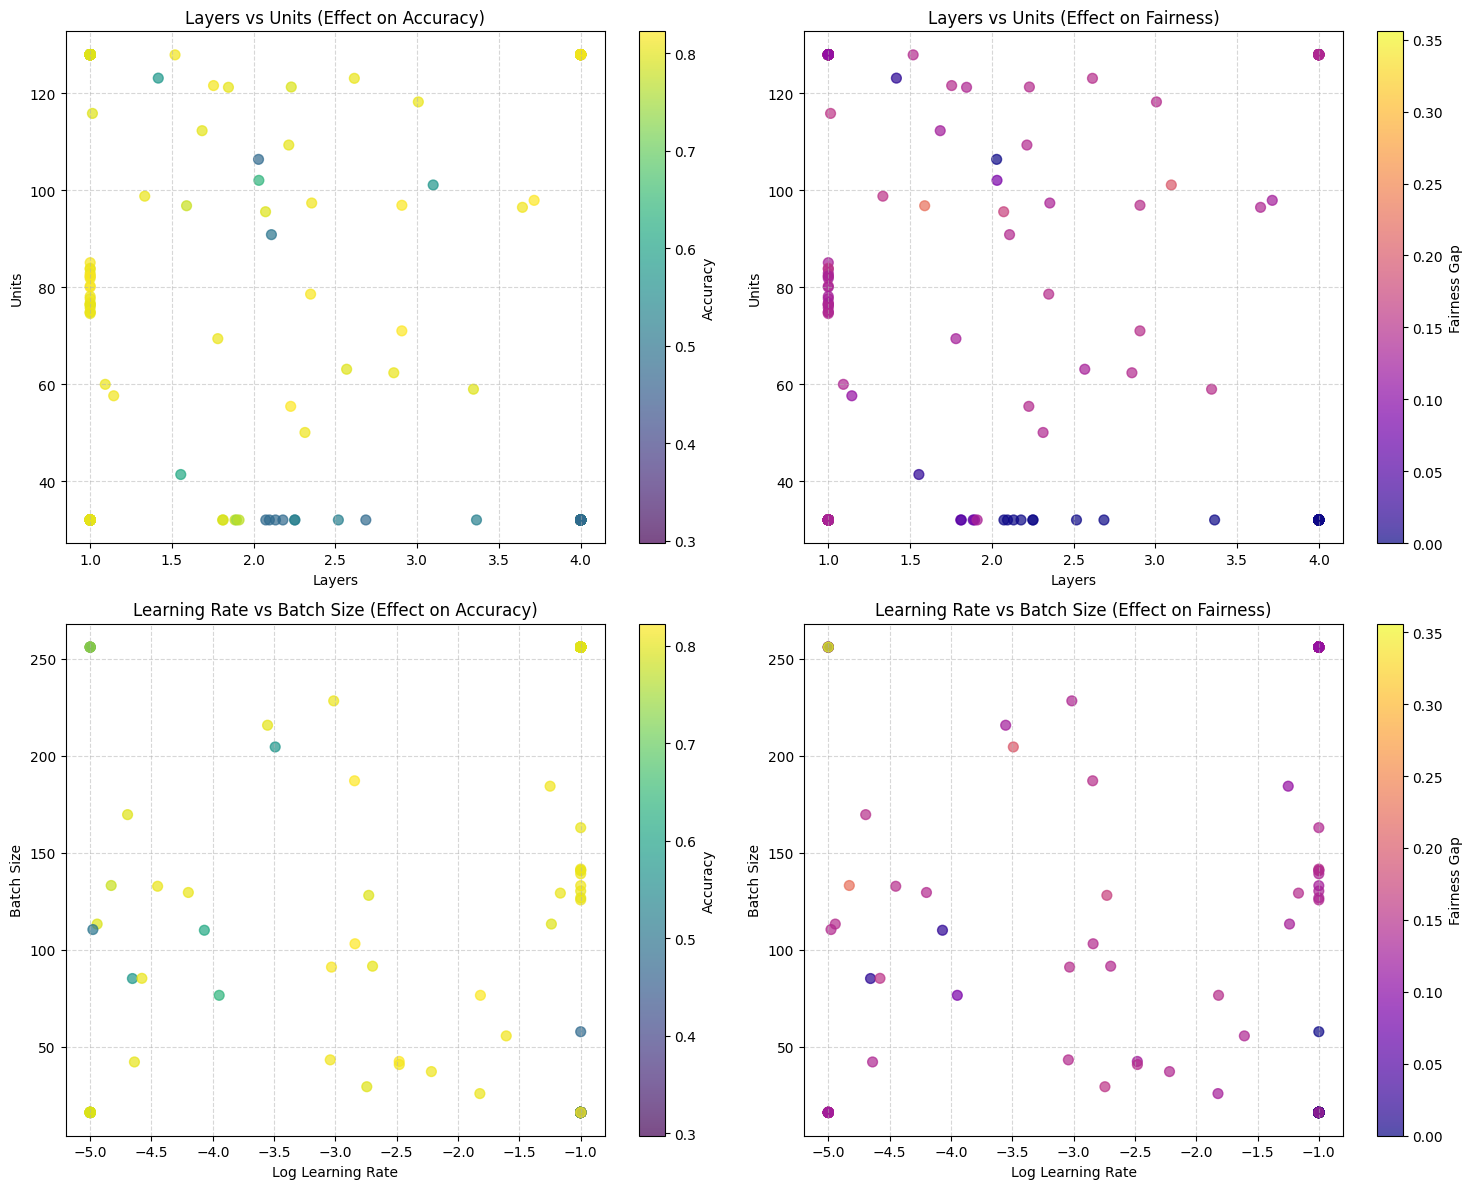

In [145]:
#  Create a heatmap visualization of hyperparameter impact on objectives
plt.figure(figsize=(15, 12))

# Create subplots for different parameter combinations
plt.subplot(2, 2, 1)
plt.scatter(all_X[:, 0].numpy(), all_X[:, 1].numpy(), c=accuracies, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(label='Accuracy')
plt.xlabel('Layers')
plt.ylabel('Units')
plt.title('Layers vs Units (Effect on Accuracy)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 2)
plt.scatter(all_X[:, 0].numpy(), all_X[:, 1].numpy(), c=fairness_values, cmap='plasma', alpha=0.7, s=50)
plt.colorbar(label='Fairness Gap')
plt.xlabel('Layers')
plt.ylabel('Units')
plt.title('Layers vs Units (Effect on Fairness)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 3)
plt.scatter(all_X[:, 2].numpy(), all_X[:, 3].numpy(), c=accuracies, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(label='Accuracy')
plt.xlabel('Log Learning Rate')
plt.ylabel('Batch Size')
plt.title('Learning Rate vs Batch Size (Effect on Accuracy)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 4)
plt.scatter(all_X[:, 2].numpy(), all_X[:, 3].numpy(), c=fairness_values, cmap='plasma', alpha=0.7, s=50)
plt.colorbar(label='Fairness Gap')
plt.xlabel('Log Learning Rate')
plt.ylabel('Batch Size')
plt.title('Learning Rate vs Batch Size (Effect on Fairness)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("botorch_multi_objective_heatmaps.png")
plt.show()